In [1]:
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import numpy as np
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import keras.backend as K
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2), K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())


def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())


def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())


def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())


def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())


def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())


def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)


def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) / K.cast(class_count, K.floatx())


def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def weight_variable(shape):
    return K.truncated_normal(shape, stddev = 0.01)

In [3]:
#データの読み込み
use_data = pd.read_csv(filepath_or_buffer="multi_data.csv", encoding="utf_8", sep=",")
print(len(use_data))
use_data.info()
#NaNデータの0埋め
use_data = use_data.fillna('0')

20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
screen_name    20000 non-null object
user_id        20000 non-null float64
tweet_id       20000 non-null float64
tweet          20000 non-null object
tweet2         20000 non-null object
postdate       20000 non-null object
cos_day        20000 non-null float64
sin_day        20000 non-null float64
tag            20000 non-null object
image_url      20000 non-null object
image          20000 non-null int64
retweet        20000 non-null float64
tag2           6063 non-null object
user_id2       20000 non-null int64
dtypes: float64(5), int64(2), object(7)
memory usage: 2.1+ MB


In [4]:
maxlen = 50
tag_maxlen = 10
train = 0.7
validation = 0.1
max_words = 20000

#データをランダムにシャッフル
use_data_s = use_data.sample(frac=1, random_state=150)

# word indexを作成
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(use_data_s['tweet2'])
tokenizer.fit_on_texts(use_data_s['tag2'])
sequences = tokenizer.texts_to_sequences(use_data_s['tweet2'])
sequences2 = tokenizer.texts_to_sequences(use_data_s['tag2'])

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)
t_data =  pad_sequences(sequences2, maxlen=tag_maxlen)

#user_idをnp行列に変換
post_user = np.array(use_data['user_id2'])
#imageをnp行列に変換
img = np.array(use_data['image'])
#sin,cosデータをまとめてnp行列へ
date = use_data_s[['cos_day','sin_day']]
p_date = date.values

#ラベルをバイナリの行列に変換
categorical_labels = to_categorical(use_data_s['retweet'])
labels = np.asarray(categorical_labels)

print("Shape of data tensor:{}".format(data.shape))
print("Shape of t_data tensor:{}".format(t_data.shape))
print("Shape of post_user tensor:{}".format(post_user.shape))
print("Shape of img tensor:{}".format(img.shape))
print("Shape of p_date tensor:{}".format(p_date.shape))
print("Shape of label tensor:{}".format(labels.shape))


indices = [int(len(labels) * n) for n in [train, train + validation]]
x1_train, x1_val, x1_test = np.split(data, indices)
x2_train, x2_val, x2_test = np.split(t_data, indices)
x3_train, x3_val, x3_test = np.split(post_user, indices)
x4_train, x4_val, x4_test = np.split(img, indices)
x5_train, x5_val, x5_test = np.split(p_date, indices)
y_train, y_val, y_test = np.split(labels, indices)

Found 20620 unique tokens.
Shape of data tensor:(20000, 50)
Shape of t_data tensor:(20000, 10)
Shape of post_user tensor:(20000,)
Shape of img tensor:(20000,)
Shape of p_date tensor:(20000, 2)
Shape of label tensor:(20000, 2)


In [5]:
p_input = Input(shape=(50, ), dtype='int32', name='Input_postText')
t_input = Input(shape=(10, ), dtype='int32', name='Input_tag')
u_input = Input(shape=(1,), name='Input_id')
i_input = Input(shape=(1,), name='Input_image')
d_input = Input(shape=(2,), name='Input_postdate')

#テキストとタグの学習
x = concatenate([p_input, t_input], name='merge1')
em = Embedding(input_dim=20620, output_dim=60, input_length=60, name='Embedding')(x)
d_em = Dropout(0.5)(em)
lstm_out = LSTM(32, kernel_initializer=weight_variable, name='LSTM')(d_em)
d_lstm_out = Dropout(0.5)(lstm_out)

#3つ目のデータ学習
user = Dense(16, activation='elu', name='user_dence')(u_input)
d_user = Dropout(0.5)(user)

#4つ目のデータ学習
image = Dense(16, activation='elu', name='image_dence')(i_input)
d_image = Dropout(0.5)(image)

#5つ目のデータ学習
pdate = Dense(16, activation='elu', name='pdate_dence')(d_input)
d_pdate = Dropout(0.5)(pdate)

x2 = concatenate([d_lstm_out, d_user, d_image, d_pdate], name='merge2')
m2 = Dense(16, activation='elu', name = 'dence')(x2)
d_m2 = Dropout(0.5)(m2)
output = Dense(2, activation='softmax', name = 'output')(d_m2)

model = Model(inputs=[p_input, t_input, u_input, i_input, d_input], outputs = output)
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['acc', macro_precision, macro_recall, macro_f_measure])
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_image/model8.png')

early_stopping = EarlyStopping(patience=0, verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_postText (InputLayer)     (None, 50)           0                                            
__________________________________________________________________________________________________
Input_tag (InputLayer)          (None, 10)           0                                            
__________________________________________________________________________________________________
merge1 (Concatenate)            (None, 60)           0           Input_postText[0][0]             
                                                                 Input_tag[0][0]                  
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 60, 60)       1237200     merge1[0][0]                     
__________

In [6]:
history = model.fit([x1_train, x2_train, x3_train, x4_train, x5_train], y_train,
                    epochs=100, 
                    batch_size=256,
                    validation_data=([x1_val, x2_val, x3_val, x4_val, x5_val], y_val),
                    callbacks=[early_stopping])

Train on 14000 samples, validate on 1999 samples
Epoch 1/100
14000/14000 [==============================] - 10s 687us/step - loss: 0.9499 - acc: 0.5034 - macro_precision: 0.5033 - macro_recall: 0.5034 - macro_f_measure: 0.5034 - val_loss: 0.6941 - val_acc: 0.5158 - val_macro_precision: 0.5782 - val_macro_recall: 0.5097 - val_macro_f_measure: 0.5339
Epoch 2/100
14000/14000 [==============================] - 7s 510us/step - loss: 0.7823 - acc: 0.5035 - macro_precision: 0.5038 - macro_recall: 0.5039 - macro_f_measure: 0.5038 - val_loss: 0.6829 - val_acc: 0.5438 - val_macro_precision: 0.5881 - val_macro_recall: 0.5398 - val_macro_f_measure: 0.5628
Epoch 3/100
14000/14000 [==============================] - 7s 465us/step - loss: 0.7159 - acc: 0.5486 - macro_precision: 0.5490 - macro_recall: 0.5488 - macro_f_measure: 0.5489 - val_loss: 0.6289 - val_acc: 0.6688 - val_macro_precision: 0.6773 - val_macro_recall: 0.6673 - val_macro_f_measure: 0.6723
Epoch 4/100
14000/14000 [======================

In [7]:
loss_and_metrics = model.evaluate([x1_test, x2_test, x3_test, x4_test, x5_test], y_test)
print(loss_and_metrics)

4001/4001 [==============================] - 1s 336us/step
[0.5005881578475981, 0.7698075481129718, 0.7740316378924287, 0.7705614608962724, 0.7721616119719898]


In [14]:
model.metrics_names

['loss', 'acc', 'macro_precision', 'macro_recall', 'macro_f_measure']

In [13]:
classes = model.predict([x1_test, x2_test, x3_test, x4_test, x5_test])
#予測結果を保存して与えたデータと結合
columns = ['not publish', 'publish']
result = pd.DataFrame(classes, columns = columns)
test_data = use_data_s[15998:19999]
n_test_data = test_data.reset_index()
predict_result = n_test_data.join(result)
predict_result.drop(['user_id','tweet_id','tweet2', 'cos_day','sin_day', 'image_url', 'tag2', 'user_id2'], axis=1, inplace=True)

In [ ]:
#予測結果の書き出し
predict_result.to_csv("result/O/result.csv",index=False, sep=",")

<Figure size 432x288 with 0 Axes>

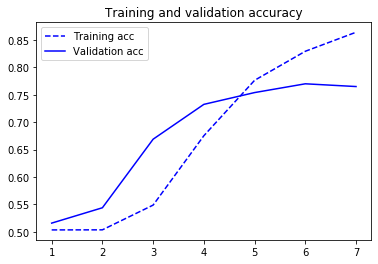

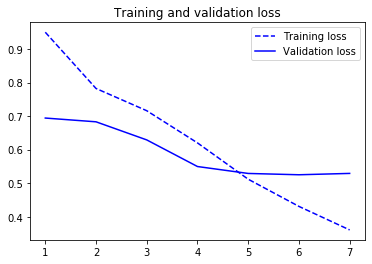

<Figure size 432x288 with 0 Axes>

In [8]:
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig("result/0/test_and_val_acc.png")

plt.figure()

plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig("result/O/test_and_val_loss.png")

plt.figure()

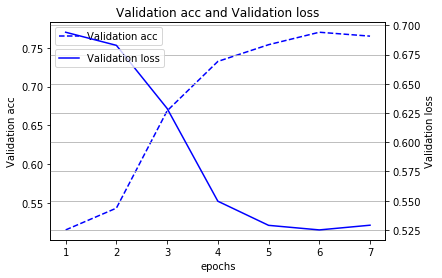

In [9]:
fig = plt.figure()
ax_acc = fig.add_subplot(111)
ax_acc.plot(epochs, val_acc, 'b--', label='Validation acc')
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=10)

ax_loss = ax_acc.twinx()
ax_loss.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=10)
plt.title('Validation acc and Validation loss')
ax_acc.set_xlabel('epochs')
ax_acc.set_ylabel('Validation acc')
ax_loss.grid(True)
ax_loss.set_ylabel('Validation loss')
#plt.savefig("result/O/val_acc_loss.png")
plt.show()

In [ ]:
model.save('Datas/model8_dO.h5')